In [1]:
import os
import logging
import yaml
import json
import pickle
import torch
import numpy as np
import pandas as pd
import xarray as xr
import seqdata as sd
import seqpro as sp
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import seaborn as sns

from tangermeme.predict import predict
from bpnetlite.bpnet import BPNet, CountWrapper, ProfileWrapper, ControlWrapper, _ProfileLogitScaling
from tangermeme.deep_lift_shap import deep_lift_shap, _nonlinear
import modiscolite
from modiscolite.util import calculate_window_offsets

from eugene.utils import (
    merge_parameters,
    check_for_gpu,
)
from eugene.plot.performance import scatter

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


/cellar/users/aklie/opt/miniconda3/envs/eugene_tools/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path_params = "/cellar/users/aklie/projects/ML4GLand/tutorials/bulk_atac_basepair/eugene/chrombpnet/K562_ATAC-seq_chrombpnet.yaml"
path_out = "/cellar/users/aklie/projects/ML4GLand/tutorials/bulk_atac_basepair/eugene/chrombpnet/fold_0/0.5"
overwrite = False
os.makedirs(path_out, exist_ok=True)

In [3]:
params = yaml.safe_load(open(path_params))
params

{'name': 'K562_ATAC-seq_chrombpnet_fold_0',
 'threads': 4,
 'random_state': 1234,
 'seqdata': {'path': '/cellar/users/aklie/projects/ML4GLand/tutorials/bulk_atac_basepair/eugene/prep_dataset/0.5/K562_ATAC-seq.minimal.seqdata',
  'seq_var': 'seq',
  'cov_var': 'cov',
  'fold': 'fold_0',
  'seq_length': 2114,
  'target_length': 1000,
  'max_jitter': 512,
  'max_counts': 999999,
  'min_counts': 0,
  'outlier_threshold': 0.9999,
  'neg_sampling_ratio': 0.1},
 'model': {'n_filters': 512,
  'n_layers': 8,
  'n_outputs': 1,
  'alpha': None,
  'bias_model': '/cellar/users/aklie/projects/ML4GLand/tutorials/bulk_atac_basepair/eugene/bias_model/fold_0/0.5/K562_ATAC-seq_bias_fold_0.torch'},
 'training': {'learning_rate': 0.001,
  'batch_size': 64,
  'max_epochs': 50,
  'validation_iter': 1000,
  'rc_augment': True},
 'evaluation': {'batch_size': 256},
 'attribution': {'batch_size': 128, 'subsample': 30000, 'n_shuffles': 20},
 'modisco': {'n_seqlets': 50000,
  'window': 500,
  'motif_db': '/cellar/

In [4]:
default_params = {
    "seqdata": {
        "ctrl_var": None,
        "overwrite": False,
    },
    "model": {
        "n_control_tracks": None,
    },
}

In [5]:
# Merge with default parameters
params = merge_parameters(path_params, default_params)

# Log parameters
message=("--- Parameters ---\n")
for key, value in params.items():
    message += f"\t{key}: "
    if isinstance(value, dict):
        for key, value in value.items():
            message += f"\n\t\t{key}: {value}"
        message += "\n"
    else:
        message += f"{value}\n"
message += "\n"
print(message)

--- Parameters ---
	name: K562_ATAC-seq_chrombpnet_fold_0
	threads: 4
	random_state: 1234
	seqdata: 
		path: /cellar/users/aklie/projects/ML4GLand/tutorials/bulk_atac_basepair/eugene/prep_dataset/0.5/K562_ATAC-seq.minimal.seqdata
		seq_var: seq
		cov_var: cov
		fold: fold_0
		seq_length: 2114
		target_length: 1000
		max_jitter: 512
		max_counts: 999999
		min_counts: 0
		outlier_threshold: 0.9999
		neg_sampling_ratio: 0.1
		ctrl_var: None
		overwrite: False
	model: 
		n_filters: 512
		n_layers: 8
		n_outputs: 1
		alpha: None
		bias_model: /cellar/users/aklie/projects/ML4GLand/tutorials/bulk_atac_basepair/eugene/bias_model/fold_0/0.5/K562_ATAC-seq_bias_fold_0.torch
		n_control_tracks: None
	training: 
		learning_rate: 0.001
		batch_size: 64
		max_epochs: 50
		validation_iter: 1000
		rc_augment: True
	evaluation: 
		batch_size: 256
	attribution: 
		batch_size: 128
		subsample: 30000
		n_shuffles: 20
	modisco: 
		n_seqlets: 50000
		window: 500
		motif_db: /cellar/users/aklie/projects/ML4GL

In [6]:
# Grab params
name = params["name"]
threads = params["threads"]
random_state = params["random_state"]

# Check for GPU
device = check_for_gpu()
if device == torch.device("cpu"):
    raise ValueError("Cannot currently train bpnet-lite models on CPU. Exiting.")

In [7]:
#-------------- Load SeqData --------------#
print("--- Loading SeqData ---")
path_seqdata = params["seqdata"]["path"]
seq_var = params["seqdata"]["seq_var"]
cov_var = params["seqdata"]["cov_var"]
ctrl_var = params["seqdata"]["ctrl_var"]
fold = params["seqdata"]["fold"]
seq_length = params["seqdata"]["seq_length"]
target_length = params["seqdata"]["target_length"]
max_jitter = params["seqdata"]["max_jitter"]
max_counts = params["seqdata"]["max_counts"]
min_counts = params["seqdata"]["min_counts"]
outlier_threshold = params["seqdata"]["outlier_threshold"]

# Load the data
print(f"Reading sequence data from {path_seqdata}")
sdata = sd.open_zarr(path_seqdata)

# Define the trimming
trimming = (seq_length - target_length) // 2
seqs_start = (sdata.dims["_length"] // 2) - (seq_length // 2)
counts_start = (sdata.dims["_length"] // 2) - (target_length // 2)
print(f"Sequence length is {seq_length}")
print(f"Target length is {target_length}")
print(f"Trimming is {trimming}\n")

# Check if prefix.torch exists, if it does and overwrite is False, raise an error
prefix = os.path.join(path_out, name)

--- Loading SeqData ---
Reading sequence data from /cellar/users/aklie/projects/ML4GLand/tutorials/bulk_atac_basepair/eugene/prep_dataset/0.5/K562_ATAC-seq.minimal.seqdata
Sequence length is 2114
Target length is 1000
Trimming is 557



In [8]:
generate = True
if not overwrite and os.path.exists(prefix + ".torch"):
    print(f"{prefix}.torch already exists. Set overwrite=True to overwrite.")
    generate = False
    print("Loading model from file, will only evaluate on test data.")
if generate:
    #-------------- Split the data --------------#
    print("--- Splitting the data ---")
    training_idx = np.where(sdata[fold].isin(["train", "valid"]))[0]
    training_data = sdata.isel(_sequence=training_idx)
    print(f"# training seqs: {training_data.dims['_sequence']}")

    # Sample neg_sampling_ratio negative sequences (type == "negative")
    neg_sampling_ratio = params["seqdata"]["neg_sampling_ratio"]
    if neg_sampling_ratio is not None:
        print(f"Sampling {neg_sampling_ratio} negative sequences")
        neg_idx = np.where(sdata.type.values == "negative")[0]
        loci_idx = np.where(sdata.type.values == "loci")[0]
        neg_idx = np.random.choice(neg_idx, size=int(neg_sampling_ratio * len(loci_idx)), replace=False)
        training_data = sdata.isel(_sequence=sorted(np.concatenate([loci_idx, neg_idx])))
        print(f"# training seqs after sampling negative sequences: {training_data.dims['_sequence']}")
    
    # -------------- Filter the data --------------#
    print("--- Filtering the data ---")
    print(f"Filtering based on total counts between {min_counts} and {max_counts}")
    training_cov = training_data[cov_var].values
    training_counts = training_cov[..., counts_start:counts_start + target_length].sum(axis=(1,2))
    counts_msk = (training_counts <= max_counts) & (training_counts >= min_counts)
    if outlier_threshold is not None:
        print(f"Further filtering based on outlier threshold of {outlier_threshold}")
        filt_counts = training_counts[counts_msk]
        upper_thresh = np.quantile(filt_counts, outlier_threshold)
        lower_thresh = np.quantile(filt_counts, 1 - outlier_threshold)
        outlier_msk = (training_counts <= upper_thresh) & (training_counts >= lower_thresh)
    else:
        outlier_msk = counts_msk
    training_data = training_data.isel(_sequence=outlier_msk)
    print(f"# training seqs after filtering: {training_data.dims['_sequence']}\n")

/cellar/users/aklie/projects/ML4GLand/tutorials/bulk_atac_basepair/eugene/chrombpnet/fold_0/0.5/K562_ATAC-seq_chrombpnet_fold_0.torch already exists. Set overwrite=True to overwrite.
Loading model from file, will only evaluate on test data.


In [9]:
#-------------- Instantiate the model --------------#
print("--- Instantiating a ChromBPNet model ---")
n_filters = params["model"]["n_filters"]
n_layers = params["model"]["n_layers"]
n_outputs = 1
n_control_tracks = 0 if params["model"]["n_control_tracks"] is None else params["model"]["n_control_tracks"]
path_bias = params["model"]["bias_model"]

# Load the bias model
bias_model = torch.load(path_bias, map_location=device)

--- Instantiating a ChromBPNet model ---


In [10]:
# Get alpha
alpha = params["model"]["alpha"]
if alpha is None:
    print("Computing counts loss weight")
    alpha = np.median(training_counts[outlier_msk]) / 10
    print(f"Counts loss weight is {alpha}\n")

Computing counts loss weight


NameError: name 'training_counts' is not defined

In [12]:
accessibility_model = BPNet(
    n_filters=n_filters,
    n_layers=n_layers,
    n_outputs=n_outputs,
    n_control_tracks=n_control_tracks,
    trimming=trimming,
    alpha=alpha,
    name=prefix + ".accessibility",
    verbose=True,
)

In [13]:
from bpnetlite import ChromBPNet

In [14]:
arch = ChromBPNet(bias=bias_model, accessibility=accessibility_model, name=prefix)
print(arch)

ChromBPNet(
  (bias): BPNet(
    (iconv): Conv1d(4, 128, kernel_size=(21,), stride=(1,), padding=(10,))
    (irelu): ReLU()
    (rconvs): ModuleList(
      (0): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
      (1): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
      (2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
      (3): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(16,), dilation=(16,))
    )
    (rrelus): ModuleList(
      (0-3): 4 x ReLU()
    )
    (fconv): Conv1d(128, 1, kernel_size=(75,), stride=(1,), padding=(37,))
    (linear): Linear(in_features=128, out_features=1, bias=True)
  )
  (accessibility): BPNet(
    (iconv): Conv1d(4, 512, kernel_size=(21,), stride=(1,), padding=(10,))
    (irelu): ReLU()
    (rconvs): ModuleList(
      (0): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
      (1): Conv1d(512, 512, kernel_size=(3,), stride=(1

In [102]:
#-------------- Train the model --------------#
print("--- Training the model ---")
learning_rate = params["training"]["learning_rate"]
batch_size = params["training"]["batch_size"]
max_epochs = params["training"]["max_epochs"]
validation_iter = params["training"]["validation_iter"]
rc_augment = params["training"]["rc_augment"]
rng = np.random.default_rng(random_state)
if ctrl_var is not None:
    def transform(batch):
        if max_jitter > 0:
            batch[seq_var], batch[cov_var], batch[ctrl_var] = sp.jitter(batch[seq_var], batch[cov_var], batch[ctrl_var], max_jitter=max_jitter, length_axis=-1, jitter_axes=0)
            batch[cov_var] = batch[cov_var][..., trimming:-trimming]
            batch[ctrl_var] = batch[ctrl_var][..., trimming:-trimming]
        else:
            batch[seq_var] = batch[seq_var][..., seqs_start:seqs_start + seq_length]
            batch[cov_var] = batch[cov_var][..., counts_start:counts_start + target_length]
            batch[ctrl_var] = batch[ctrl_var][..., counts_start:counts_start + target_length]
        batch[seq_var] = sp.DNA.ohe(batch[seq_var]).transpose(0, 2, 1)
        if rc_augment and rng.choice(2) == 1:
            batch[seq_var] = sp.reverse_complement(batch[seq_var], alphabet=sp.DNA, length_axis=-1, ohe_axis=1).copy()
            batch[cov_var] = np.flip(batch[cov_var], axis=-1).copy()
            batch[ctrl_var] = np.flip(batch[ctrl_var], axis=-1).copy()
        return batch
else:
    def transform(batch):
        if max_jitter > 0:
            batch[seq_var], batch[cov_var] = sp.jitter(batch[seq_var], batch[cov_var], max_jitter=max_jitter, length_axis=-1, jitter_axes=0)  # jitter
            batch[cov_var] = batch[cov_var][..., trimming:-trimming]  # trim
        else:
            batch[seq_var] = batch[seq_var][..., seqs_start:seqs_start + seq_length]
            batch[cov_var] = batch[cov_var][..., counts_start:counts_start + target_length]
        batch[seq_var] = sp.DNA.ohe(batch[seq_var]).transpose(0, 2, 1)  # one hot encode
        if rc_augment and rng.choice(2) == 1:
            batch[seq_var] = sp.reverse_complement(batch[seq_var], alphabet=sp.DNA, length_axis=-1, ohe_axis=1).copy()
            batch[cov_var] = np.flip(batch[cov_var], axis=-1).copy()
        return batch

--- Training the model ---


In [103]:
# Get the train dataloader
vars = [seq_var, cov_var] if ctrl_var is None else [seq_var, cov_var, ctrl_var]
print(f"Creating the train dataloader with variables: {vars}")
train_idx = np.where(training_data[fold] == "train")[0]
train_data = training_data.isel(_sequence=train_idx).load()
train_dl = sd.get_torch_dataloader(
    train_data,
    sample_dims=['_sequence'],
    variables=vars,
    prefetch_factor=None,
    transform=transform,
    batch_size=batch_size,
    shuffle=True,
    return_tuples=True
)
print(f"Dataloader contains {len(train_dl)} batches")
batch = next(iter(train_dl))

Creating the train dataloader with variables: ['seq', 'cov']
Dataloader contains 3225 batches


In [104]:
# Get the validation data
valid_idx = np.where(training_data[fold] == "valid")[0]
valid_data = training_data.isel(_sequence=valid_idx)
if ctrl_var is None:
    print(f"Batch looks like: {batch[0].shape}, {batch[1].shape}")
    X_ctl_valid = None
else:
    print(f"Batch looks like: {batch[0].shape}, {batch[1].shape}, {batch[2].shape}")
    X_ctl_valid = torch.tensor(valid_data[ctrl_var].values[..., counts_start:counts_start + target_length], dtype=torch.float32)
X_valid = torch.tensor(sp.ohe(valid_data[seq_var].values[:, seqs_start:seqs_start + seq_length], alphabet=sp.DNA).transpose(0, 2, 1), dtype=torch.float32)
y_valid = torch.tensor(valid_data[cov_var].values[..., counts_start:counts_start + target_length], dtype=torch.float32)
print(f"Validation data shapes: {X_valid.shape}, {y_valid.shape}")
if X_ctl_valid is not None:
    print(f"Validation control data shape: {X_ctl_valid.shape}")

Batch looks like: torch.Size([64, 4, 2114]), torch.Size([64, 1, 1000])
Validation data shapes: torch.Size([19758, 4, 2114]), torch.Size([19758, 1, 1000])


In [105]:
# Move the model to the GPU and prepare the optimizer
arch.cuda()
optimizer = torch.optim.Adam(arch.parameters(), lr=learning_rate)
print(f"Optimizer: {optimizer}")

Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


In [ ]:
# Use the models fit_generator method to train the model
print("Fitting the model")
arch.fit(
    train_dl,
    optimizer,
    X_valid=X_valid,
    y_valid=y_valid,
    max_epochs=max_epochs,
    validation_iter=100,
)

Fitting the model
Epoch	Iteration	Training Time	Validation Time	Training MNLL	Training Count MSE	Validation MNLL	Validation Profile Correlation	Validation Count Pearson	Validation Count MSE	Saved?
0	0	0.0784	19.9469	1102.8982	8.1176	1461.2247	0.5814768	-0.49701312	2432.7896	True
0	100	19.4687	19.6798	1232.3691	8.73	1180.0857	0.67765784	0.16837353	8.589	True
0	200	19.4912	19.7019	1113.8108	8.3522	1185.489	0.6750057	0.16823225	8.5883	False
0	300	19.4881	19.7033	1060.8896	8.0917	1171.6475	0.6775518	0.16790468	8.5862	True
0	400	19.4859	19.6994	1245.4434	8.9466	1167.8865	0.6805395	0.16635057	8.5765	True
0	500	19.4944	19.7062	1212.5472	1.3094	1172.0259	0.6777533	0.53520316	1.962	True
0	600	19.4882	19.6998	1310.5752	1.2685	1203.8654	0.6718181	0.55039525	1.7129	False
0	700	19.4822	19.6945	979.5961	1.5919	1156.2998	0.68392307	0.5303401	1.8876	True
0	800	19.4631	19.687	987.5355	1.6372	1155.8967	0.6834537	0.55007964	1.6132	True
0	900	19.475	19.6839	1039.1317	2.1396	1170.4404	0.682307	0.54989505	1

In [25]:
alpha = arch.accessibility.alpha

In [32]:
log_df[log_df["Iteration"].duplicated()]

,Epoch,Iteration,Training Time,Validation Time,Training MNLL,Training Count MSE,Validation MNLL,Validation Profile Correlation,Validation Count Pearson,Validation Count MSE,Saved?,Training Loss,Validation Loss
33,1,0,5.517701,19.500207,932.241760,1.544799,1056.473267,0.732217,0.628830,1.216397,True,1056.289156,1154.149911
34,1,100,19.314644,19.495747,1012.177124,0.810664,1052.048584,0.732858,0.633140,1.231875,True,1077.273419,1150.968151
35,1,200,19.317626,19.488326,1131.588135,1.736926,1050.762207,0.732823,0.633143,1.216017,True,1271.063270,1148.408392
36,1,300,19.309565,19.485497,1040.878662,1.462553,1050.021606,0.734956,0.638465,1.206140,True,1158.321651,1146.874613
37,1,400,19.316967,19.487063,969.075684,1.599156,1053.083252,0.734584,0.634420,1.286828,False,1097.487903,1156.415553
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1645,49,2800,19.244409,19.402450,990.148376,0.286468,948.757568,0.774852,0.731137,0.936274,False,1013.151783,1023.940403
1646,49,2900,19.246675,19.418544,726.764648,0.377520,952.912842,0.773578,0.730125,0.938989,False,757.079504,1028.313667
1647,49,3000,19.255188,19.397863,744.717346,0.616022,953.682739,0.773991,0.730778,0.942902,False,794.183931,1029.397801
1648,49,3100,19.258972,19.398536,776.912598,0.262185,954.717102,0.773742,0.728880,0.953527,False,797.966047,1031.285308


In [26]:
# log dataframe
log_df = pd.read_csv(prefix + ".log", sep="\t")
log_df["Training Loss"] = log_df["Training MNLL"] + alpha*log_df["Training Count MSE"]
log_df["Validation Loss"] = log_df["Validation MNLL"] + alpha*log_df["Validation Count MSE"]
with sns.plotting_context("notebook", font_scale=1.5):
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=log_df, x="Iteration", y="Validation Loss", label="Validation Loss")
    sns.lineplot(data=log_df, x="Iteration", y="Training Loss", label="Training Loss")
    plt.xlabel("Iteration")
    plt.ylabel("Total Loss")
    plt.tight_layout()
    plt.savefig(prefix + "_loss.png")
    plt.close()

In [24]:
#-------------- Test data evaluation the model --------------#
print("--- Evaluating the model on test data ---")
batch_size = params["evaluation"]["batch_size"]

# Load the model
print("Loading best model from file")
arch = torch.load(prefix + ".torch").cuda()

--- Evaluating the model on test data ---
Loading best model from file


In [33]:
# Test data        
test_idx = np.where(sdata[fold] == "test")[0]
test_data = sdata.isel(_sequence=test_idx)
print(f"# test seqs: {test_data.dims['_sequence']}\n")

# Get predictions
test_out = os.path.join(path_out, f"{name}.test.seqdata")
generate = True
if os.path.exists(test_out):
    if not overwrite:
        print("Test SeqData already exists. Set overwrite to true in config to overwrite.")
        generate = False
        print(f"Loaded test SeqData from {test_out}")
        test_data = sd.open_zarr(test_out)
if generate:
    print("Predicting on test data")
    true_counts = torch.tensor(test_data[cov_var].values[..., counts_start:counts_start + target_length].sum(axis=-1), dtype=torch.float32)
    test_data["log_counts"] = xr.DataArray(torch.log(true_counts+1).numpy(), dims=["_sequence", "cov_sample"])
    X_test = torch.tensor(sp.ohe(test_data[seq_var].values[:, seqs_start:seqs_start + seq_length], alphabet=sp.DNA).transpose(0, 2, 1), dtype=torch.float32)
    y_profiles, y_counts = predict(arch, X_test, batch_size=batch_size, device="cuda", verbose=True)
    test_data[f"{fold}_log_counts_pred"] = xr.DataArray(y_counts.cpu().numpy(), dims=["_sequence", "cov_sample"])
    test_data[f"{fold}_profile_pred"] = xr.DataArray(y_profiles.cpu().numpy(), dims=["_sequence", "cov_sample", "_target_length"])     
    sd.to_zarr(test_data, test_out, mode="w")        
    print(f"Saved test SeqData to {test_out}")

# test seqs: 107270

Predicting on test data


100%|██████████| 420/420 [02:00<00:00,  3.47it/s]


Saved test SeqData to /cellar/users/aklie/projects/ML4GLand/tutorials/bulk_atac_basepair/eugene/chrombpnet/fold_0/0.5/K562_ATAC-seq_chrombpnet_fold_0.test.seqdata


In [34]:
# Scatter plots
print("Creating scatter plots")
type_msk = (test_data["type"] == "loci")
loci_counts = test_data["log_counts"].values[type_msk]
loci_counts_pred = test_data[f"{fold}_log_counts_pred"].values[type_msk]
scatter(
    loci_counts,
    loci_counts_pred,
    figsize=(4, 4),
    xlabel="Observed Log Counts",
    ylabel="Predicted Log Counts",
    save=prefix + "_loci_counts_scatter.png",
    density=False,
    add_reference_line=False,
    return_axes=False,
)
neg_counts = test_data["log_counts"].values[~type_msk]
neg_counts_pred = test_data[f"{fold}_log_counts_pred"].values[~type_msk]
scatter(
    neg_counts,
    neg_counts_pred,
    figsize=(4, 4),
    xlabel="Observed Log Counts",
    ylabel="Predicted Log Counts",
    save=prefix + "_neg_counts_scatter.png",
    density=False,
    add_reference_line=False,
    return_axes=False,
)
counts = test_data["log_counts"].values
counts_pred = test_data[f"{fold}_log_counts_pred"].values
scatter(
    counts,
    counts_pred,
    figsize=(4, 4),
    xlabel="Observed Log Counts",
    ylabel="Predicted Log Counts",
    save=prefix + "_counts_scatter.png",
    density=False,
    add_reference_line=False,
    return_axes=False,
)

Creating scatter plots


In [35]:
from tangermeme.predict import predict

In [91]:
y_bias_profiles, y_bias_counts = predict(arch.bias, X_test, batch_size=batch_size, device="cuda", verbose=True)

100%|██████████| 420/420 [00:09<00:00, 43.17it/s]


In [ ]:
y_accessibility_profiles, y_accessibility_counts = predict(arch.accessibility, X_test, batch_size=batch_size, device="cuda", verbose=True)

In [157]:
y_full_profiles, y_full_counts = predict(arch, X_test, batch_size=batch_size, device="cuda", verbose=True)

100%|██████████| 420/420 [01:50<00:00,  3.80it/s]


In [162]:
# Find the top10 sequences with highest y_bias_counts
top10_idx = y_bias_counts.squeeze().argsort(descending=True)[:100]
top10_idx

tensor([ 80471,  80606,  38403,  38402,  38401, 107062, 103805,  13330,  13331,
         13323,  13325,  13324,  13326,  13329,  13328,  13327,  83314,  73583,
         96397,  47914,  56390,  56389,  20968,  67050,  21358,  60788,   7380,
         35337,  83454,  61896,  97250,  98964,  83449,  76224,  77184, 107005,
         62127,  66669,  41911,  41912,  63013,  63011,  63010,  63014,  63012,
         45474,  45477,  45476,  45475,  62174,  62176,  62175,  62137,  62136,
         83480,  97653,  70439,  44692,   5690,   5689,  21057,  21058,  39293,
         96398,  21442,  33310,  33309,  53665,   6314,  12929,  54766,  21710,
         97568,  99696,  47442,  47443,   2848,  66660,  26351,  65225,  95851,
         23435,  44899,  20828,  20861,  26370,  26369,  72341,  56465,  92131,
         97654,  97322,  21827,  54885,  54886,  61809,  17872,  26107,    405,
           406])

In [163]:
test_data.type.values[top10_idx]

array(['negative', 'negative', 'loci', 'loci', 'loci', 'negative',
       'negative', 'loci', 'loci', 'loci', 'loci', 'loci', 'loci', 'loci',
       'loci', 'loci', 'negative', 'negative', 'negative', 'loci', 'loci',
       'loci', 'loci', 'negative', 'loci', 'loci', 'loci', 'loci',
       'negative', 'loci', 'negative', 'negative', 'negative', 'negative',
       'negative', 'negative', 'loci', 'negative', 'loci', 'loci', 'loci',
       'loci', 'loci', 'loci', 'loci', 'loci', 'loci', 'loci', 'loci',
       'loci', 'loci', 'loci', 'loci', 'loci', 'negative', 'negative',
       'negative', 'loci', 'loci', 'loci', 'loci', 'loci', 'loci',
       'negative', 'loci', 'loci', 'loci', 'loci', 'loci', 'loci', 'loci',
       'loci', 'negative', 'negative', 'loci', 'loci', 'loci', 'negative',
       'loci', 'loci', 'negative', 'loci', 'loci', 'loci', 'loci', 'loci',
       'loci', 'negative', 'loci', 'negative', 'negative', 'negative',
       'loci', 'loci', 'loci', 'loci', 'loci', 'loci', 'loci'

In [164]:
selected_idx = top10_idx[2]

In [165]:
torch.exp(y_bias_counts[selected_idx]), torch.exp(y_accessibility_counts[selected_idx])

(tensor([98.7095]), tensor([1484.4161]))

In [166]:
def log_softmax_profile(
    y_profile,
):
    # Log softmax the predicted profile
    z = y_profile.shape
    y_profile = y_profile.reshape(y_profile.shape[0], -1)
    y_profile = torch.nn.functional.log_softmax(y_profile, dim=-1)
    y_profile = y_profile.reshape(*z)
    return y_profile

In [167]:
y_bias_profiles_probs = torch.exp(log_softmax_profile(y_bias_profiles))
y_accessibility_profiles_probs = torch.exp(log_softmax_profile(y_accessibility_profiles))
y_full_profiles_probs = torch.exp(log_softmax_profile(y_full_profiles))

In [168]:
y_bias_profile = y_bias_profiles_probs[selected_idx] * torch.exp(y_bias_counts[selected_idx])
y_accessibility_profile = y_accessibility_profiles_probs[selected_idx] * torch.exp(y_accessibility_counts[selected_idx])
y_full_profile = y_full_profiles_probs[selected_idx] * torch.exp(y_full_counts[selected_idx])

In [169]:
import seaborn as sns

def plot_tracks(tracks, interval, height=1.5, colors=None):
  _, axes = plt.subplots(len(tracks), 1, figsize=(20, height * len(tracks)), sharex=True)
  if not isinstance(axes, np.ndarray):
    axes = [axes]
  for ax, (title, y) in zip(axes, tracks.items()):
    if colors is not None:
      ax.fill_between(np.linspace(interval["start"], interval["end"], num=len(y)), y, color=colors[title])
    else:
      ax.fill_between(np.linspace(interval["start"], interval["end"], num=len(y)), y)
    ax.set_title(title)
    sns.despine(top=True, right=True, bottom=True)
  ax.set_xlabel(f"{interval['chrom']}:{interval['start']}-{interval['end']}")
  plt.tight_layout()

In [170]:
example = test_data.isel(_sequence=selected_idx)
trues = example["cov"].values.squeeze()[..., counts_start:counts_start + target_length]
full = y_full_profile.squeeze().cpu().numpy()
bias = y_bias_profile.squeeze().cpu().numpy()
accessibility = y_accessibility_profile.squeeze().cpu().numpy()
trues.shape, bias.shape, accessibility.shape

((1000,), (1000,), (1000,))

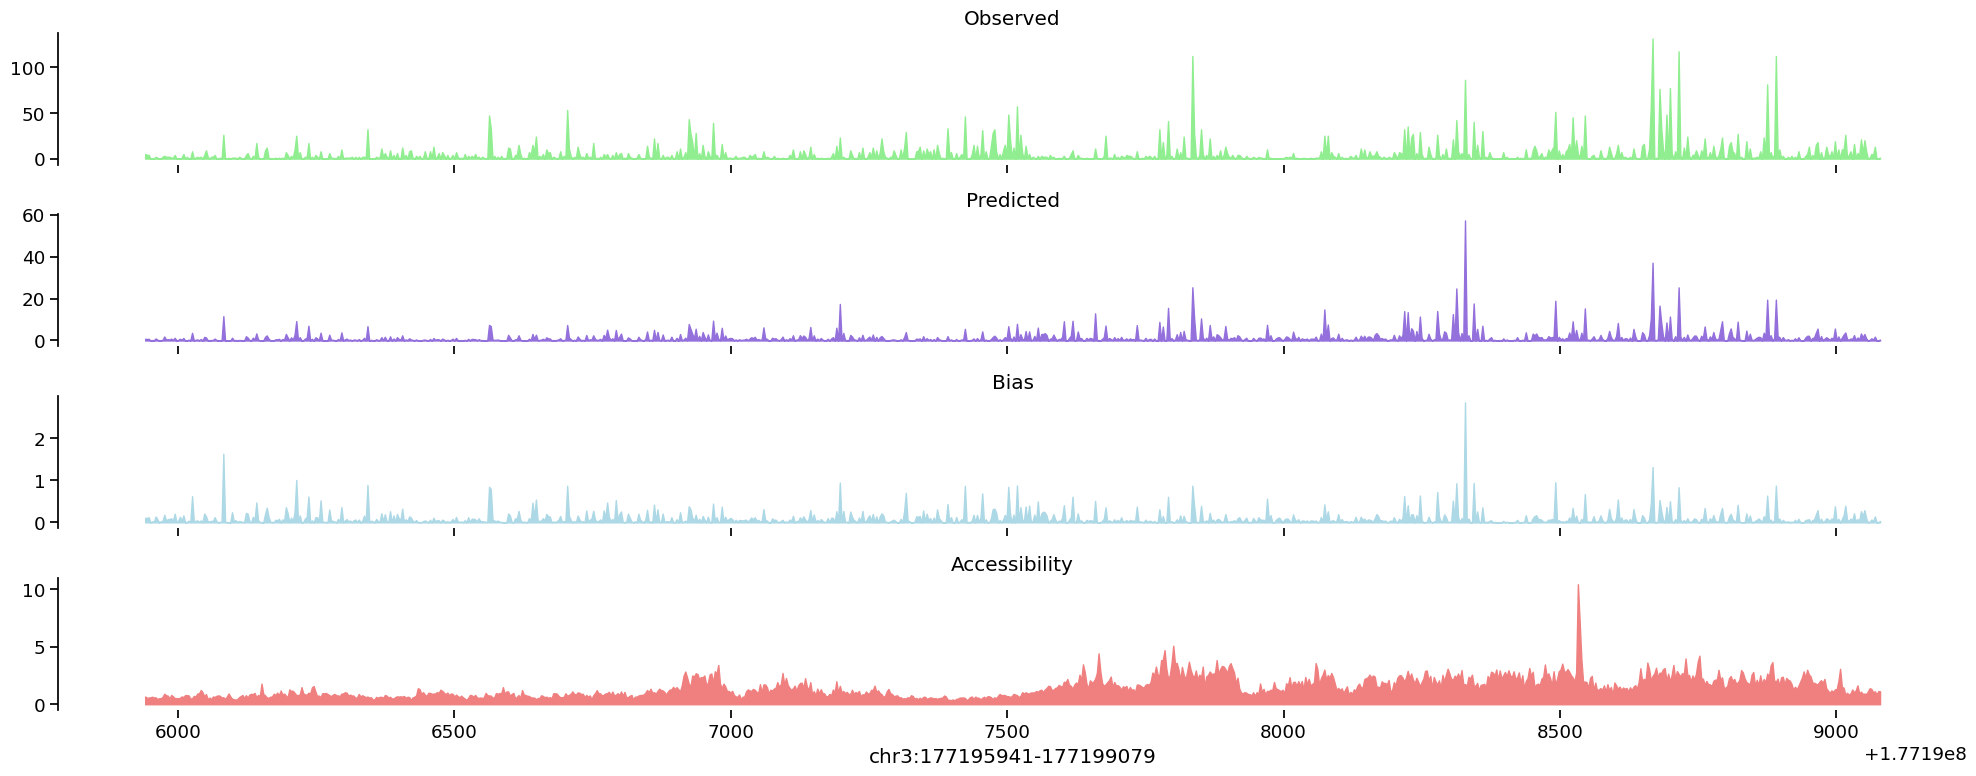

In [173]:
chrom = example["chrom"].values
chromStart = example["chromStart"].values
chromEnd = example["chromEnd"].values
interval = dict(chrom=chrom, start=chromStart, end=chromEnd)
tracks = {
    "Observed": trues,
    "Predicted": full,
    "Bias": bias,
    "Accessibility": accessibility,
}
colors = {
    "Observed": "lightgreen",
    "Predicted": "mediumpurple",
    "Bias": "lightblue",
    "Accessibility": "lightcoral",
}

with sns.plotting_context("notebook", font_scale=1.2):
    # Plot tracks
    plot_tracks(
        tracks=tracks,
        interval=interval,
        colors=colors,
        height=2,
    )

In [155]:
%matplotlib inline


In [ ]:
# Get data
example = test_data.isel(_sequence=best_idx)

preds = (torch.exp(y_profiles[best_idx])*true_counts[best_idx]).cpu().numpy().squeeze(axis=0)


In [ ]:
#-------------- Prediction bigwigs --------------#
pred_logits_wo_bias, pred_logcts_wo_bias = model_chrombpnet_nb.predict([seqs],
                                          batch_size = args.batch_size,
                                          verbose=True)

pred_logits_wo_bias = np.squeeze(pred_logits_wo_bias)


bigwig_helper.write_bigwig(softmax(pred_logits_wo_bias) * (np.expand_dims(np.exp(pred_logcts_wo_bias)[:,0],axis=1)), 
                    regions, 
                    gs, 
                    args.output_prefix + "_chrombpnet_nobias.bw", 
                    outstats_file=args.output_prefix_stats, 
                    debug_chr=args.debug_chr, 
                    use_tqdm=args.tqdm)

In [ ]:
def write_bigwig(data, regions, gs, bw_out, debug_chr=None, use_tqdm=False, outstats_file=None):
    # regions may overlap but as we go in sorted order, at a given position,
    # we will pick the value from the interval whose summit is closest to 
    # current position
    
    chr_to_idx = {}
    for i,x in enumerate(gs):
        chr_to_idx[x[0]] = i

    bw = pyBigWig.open(bw_out, 'w')
    bw.addHeader(gs)
    
    # regions may not be sorted, so get their sorted order
    order_of_regs = sorted(range(len(regions)), key=lambda x:(chr_to_idx[regions[x][0]], regions[x][1]))

    all_entries = []
    cur_chr = ""
    cur_end = 0

    iterator = range(len(order_of_regs))
    if use_tqdm:
        from tqdm import tqdm
        iterator = tqdm(iterator)

    for itr in iterator:
        # subset to chromosome (debugging)
        if debug_chr and regions[i][0]!=debug_chr:
            continue

        i = order_of_regs[itr]
        i_chr, i_start, i_end, i_mid = regions[i]
    
        if i_chr != cur_chr: 
            cur_chr = i_chr
            cur_end = 0
    
        # bring current end to at least start of current region
        if cur_end < i_start:
            cur_end = i_start
    
        assert(regions[i][2]>=cur_end)
    
        # figure out where to stop for this region, get next region
        # which may partially overlap with this one
        next_end = i_end
    
        if itr+1 != len(order_of_regs):
            n = order_of_regs[itr+1]
            next_chr, next_start, _, next_mid = regions[n]
       
            if next_chr == i_chr and next_start < i_end:
                # if next region overlaps with this, end between their midpoints
                next_end = (i_mid+next_mid)//2
       
        vals = data[i][cur_end - i_start:next_end - i_start]

        bw.addEntries([i_chr]*(next_end-cur_end), 
                       list(range(cur_end,next_end)), 
                       ends = list(range(cur_end+1, next_end+1)), 
                       values=[float(x) for x in vals])
    
        all_entries.append(vals)
        
        cur_end = next_end

    bw.close()

    all_entries = np.hstack(all_entries)
    if outstats_file != None:
        with open(outstats_file, 'w') as f:
            f.write("Min\t{:.6f}\n".format(np.min(all_entries)))
            f.write(".1%\t{:.6f}\n".format(np.quantile(all_entries, 0.001)))
            f.write("1%\t{:.6f}\n".format(np.quantile(all_entries, 0.01)))
            f.write("50%\t{:.6f}\n".format(np.quantile(all_entries, 0.5)))
            f.write("99%\t{:.6f}\n".format(np.quantile(all_entries, 0.99)))
            f.write("99.9%\t{:.6f}\n".format(np.quantile(all_entries, 0.999)))
            f.write("99.95%\t{:.6f}\n".format(np.quantile(all_entries, 0.9995)))
            f.write("99.99%\t{:.6f}\n".format(np.quantile(all_entries, 0.9999)))
            f.write("Max\t{:.6f}\n".format(np.max(all_entries)))

In [ ]:
        

            

    #-------------- Attribution --------------#
    if "attribution" in params:
        print("--- Computing attribution on 30k subsample ---")
        batch_size = params["attribution"]["batch_size"]
        subsample = params["attribution"]["subsample"]
        n_shuffles = params["attribution"]["n_shuffles"]
        
        # Write test SeqData
        attr_out = os.path.join(path_out, f"{name}.sub.attr.seqdata")
        generate = True
        if os.path.exists(attr_out):
            if not overwrite:
                print("Subsampled SeqData already exists. Set overwrite to true in config to overwrite.")
                generate = False
                print(f"Loading attribution subsample from {attr_out}")
                test_loci = sd.open_zarr(attr_out)
                X = test_loci["X_ohe"].values
                X_attr_counts = test_loci["X_attr_counts"].values
                X_attr_profile = test_loci["X_attr_profile"].values
        
        if generate:
            # Subsample loci
            print(f"Targeting {subsample} loci for attributions")
            test_loci_idx = np.where(test_data["type"] == "loci")[0]
            test_loci = test_data.isel(_sequence=test_loci_idx)
            if test_loci.dims["_sequence"] > subsample:
                random_idx = np.random.choice(test_loci.dims["_sequence"], subsample, replace=False)
                test_loci = test_loci.isel(_sequence=sorted(random_idx))
            X = torch.tensor(sp.ohe(test_loci["seq"].values[:, seqs_start:seqs_start + seq_length], alphabet=sp.DNA).transpose(0, 2, 1), dtype=torch.float32)
            n_msk = X.sum(dim=(1, 2)) == X.shape[-1]
            X = X[n_msk]
            n_idx = np.where(n_msk)[0]
            test_loci = test_loci.isel(_sequence=n_idx)
            print(f"Subsampled {subsample} loci with no non-alphabet characters")
        
            # Get count attributions
            print("Computing count attributions")
            count_wrapper = CountWrapper(ControlWrapper(arch)).cuda().eval()
            dtype = torch.float64
            X_attr_counts = deep_lift_shap(
                count_wrapper.type(dtype), 
                X.type(dtype),
                hypothetical=True,
                n_shuffles=n_shuffles,
                batch_size=batch_size,
                verbose=True,
                warning_threshold=1e-4
            )

            # Get profile attributions
            print("Computing profile attributions")
            profile_wrapper = ProfileWrapper(ControlWrapper(arch)).cuda().eval()
            X_attr_profile = deep_lift_shap(
                profile_wrapper.type(dtype), 
                X.type(dtype),
                hypothetical=True,
                additional_nonlinear_ops={_ProfileLogitScaling: _nonlinear}, 
                n_shuffles=n_shuffles,
                batch_size=batch_size,
                verbose=True,
                warning_threshold=1e-4
            )
            
            # Save attributions
            X = X.cpu().numpy()
            X_attr_counts = X_attr_counts.cpu().numpy()
            X_attr_profile = X_attr_profile.cpu().numpy()
            test_loci["X_ohe"] = xr.DataArray(X, dims=["_sequence", "_alphabet", "_trimmed_length"])
            test_loci["X_attr_counts"] = xr.DataArray(X_attr_counts, dims=["_sequence", "_alphabet", "_trimmed_length"])
            test_loci["X_attr_profile"] = xr.DataArray(X_attr_profile, dims=["_sequence", "_alphabet", "_trimmed_length"])
            sd.to_zarr(test_loci, attr_out, mode="w")
            print(f"Saved attribution subset SeqData to {attr_out}")
                

    if "modisco" in params:
        print("--- Running TFMoDISco ---")
        n_seqlets = params["modisco"]["n_seqlets"]
        window = params["modisco"]["window"]
        motif_db = params["modisco"]["motif_db"]
        
        # Get sequences for modisco
        center = X.shape[2] // 2
        start, end = calculate_window_offsets(center, window)
        sequences = X[:, :, start:end].transpose(0, 2, 1).astype('float32')

        # Counts modisco
        modisco_out = os.path.join(path_out, f"{name}_modisco_counts.h5")
        generate = True
        if os.path.exists(modisco_out):
            if not overwrite:
                print("TFMoDISco output already exists. Set overwrite to true in config to overwrite.")
                generate = False
                print(f"Loading TFMoDISco results from {modisco_out}")
        if generate:
            print("Using count attributions for TFMoDISco")
            attributions = X_attr_counts[:, :, start:end].transpose(0, 2, 1).astype('float32')
            pos_patterns, neg_patterns = modiscolite.tfmodisco.TFMoDISco(
                hypothetical_contribs=attributions, 
                one_hot=sequences,
                max_seqlets_per_metacluster=n_seqlets,
                sliding_window_size=20,
                flank_size=5,
                target_seqlet_fdr=0.05,
                n_leiden_runs=2,
                verbose=True
            )
            modiscolite.io.save_hdf5(prefix + "_modisco_counts.h5", pos_patterns, neg_patterns, window)
            print(f"Saved count attributions TFMoDISco results to {prefix}_modisco_counts.h5")
        
        # Profile modisco
        modisco_out = os.path.join(path_out, f"{name}_modisco_profile.h5")
        generate = True
        if os.path.exists(modisco_out):
            if not overwrite:
                print("TFMoDISco output already exists. Set overwrite to true in config to overwrite.")
                generate = False
                print(f"Loading TFMoDISco results from {modisco_out}")
        if generate:
            print("Using profile attributions for TFMoDISco")
            attributions = X_attr_profile[:, :, start:end].transpose(0, 2, 1).astype('float32')
            pos_patterns, neg_patterns = modiscolite.tfmodisco.TFMoDISco(
                hypothetical_contribs=attributions, 
                one_hot=sequences,
                max_seqlets_per_metacluster=n_seqlets,
                sliding_window_size=20,
                flank_size=5,
                target_seqlet_fdr=0.05,
                n_leiden_runs=2,
                verbose=True
            )
            modiscolite.io.save_hdf5(prefix + "_modisco_profile.h5", pos_patterns, neg_patterns, window)
            print(f"Saved profile attributions TFMoDISco results to {prefix}_modisco_profile.h5")
    
        print("--- Creating TFMoDISco reports ---")
        report_out = os.path.join(path_out, f"{name}_modisco_counts_report")
        generate = True
        if os.path.exists(report_out):
            if not overwrite:
                print("Counts TFMoDISco report already exists. Set overwrite to true in config to overwrite.")
                generate = False
        if generate:
            modiscolite.report.report_motifs(
                modisco_h5py=prefix + "_modisco_counts.h5",
                output_dir=prefix + "_modisco_counts_report/",
                img_path_suffix=prefix + "_modisco_counts_report/",
                meme_motif_db=motif_db,
                is_writing_tomtom_matrix=False,
                top_n_matches=3
            )
            print(f"Saved counts TFMoDISco report to {prefix}_modisco_counts_report")

        report_out = os.path.join(path_out, f"{name}_modisco_profile_report")
        generate = True
        if os.path.exists(report_out):
            if not overwrite:
                print("Profile TFMoDISco report already exists. Set overwrite to true in config to overwrite.")
                generate = False
        if generate:
            modiscolite.report.report_motifs(
                modisco_h5py=prefix + "_modisco_profile.h5",
                output_dir=prefix + "_modisco_profile_report/",
                img_path_suffix=prefix + "_modisco_profile_report/",
                meme_motif_db=motif_db,
                is_writing_tomtom_matrix=False,
                top_n_matches=3
            )
            print(f"Saved profile TFMoDISco report to {prefix}_modisco_profile_report")

    print("Done!")
